In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch

import torch.optim as optim
import torch.nn.functional as F

In [2]:
# %pip install poutyne          # to install the Poutyne library
%pip install wget             # to install the wget library in order to download data
# %pip install opencv-python    # to install the cv2 (opencv) library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=37c4f156164a294a42dc2ebb8f02f59012c3eeef6231b8e8ebb4dbbedd361669
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import wget
import zipfile
# import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
# from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(1)

In [35]:
batch_size = 32
num_epochs = 20
lr = 1e-3
dataset_location ="./datasets/"

In [36]:
from torchvision import transforms
import torch
import torchvision
import numpy as np

def get_celeba(batch_size, dataset_directory, train_val_split=0.8):
    # 1. Download this file into dataset_directory and unzip it:
    #  https://drive.google.com/open?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
    # 2. Put the `img_align_celeba` directory into the `celeba` directory!
    # 3. Dataset directory structure should look like this (required by ImageFolder from torchvision):
    #  +- `dataset_directory`
    #     +- celeba
    #        +- img_align_celeba
    #           +- 000001.jpg
    #           +- 000002.jpg
    #           +- 000003.jpg
    #           +- ...
    train_transformation = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = torchvision.datasets.ImageFolder(dataset_directory + 'celeba', train_transformation)
    dataset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 50000, replace=False))
    
    n = len(dataset)
    # test_split = train_val_split/2.0

    # n_test = int(n*test_split)
    # n_train = int((n-2*n_test)/2)
    n_test = int(5000/2)
    n_train_val = int((n-5000))
    n_train = int(train_val_split*n_train_val/2)
    n_val = int((n_train_val-(2*n_train))/2)
    print("No. of training imgs:", 2*n_train)
    print("No. of validation imgs:", 2*n_val)
    print("No. of testing imgs:", 2*n_test)
    source_train, payload_train, source_test, payload_test, source_val, payload_val = torch.utils.data.random_split(
    dataset, (n_train, n_train, n_test, n_test, n_val, n_val))

    # Prepare Data Loaders for training and validation
    source_train_loader = torch.utils.data.DataLoader(source_train, batch_size=batch_size, shuffle=True)
    source_test_loader = torch.utils.data.DataLoader(source_test, shuffle=True)
    source_val_loader = torch.utils.data.DataLoader(source_val, shuffle=True)
    payload_train_loader = torch.utils.data.DataLoader(payload_train, batch_size=batch_size, shuffle=True)
    payload_test_loader = torch.utils.data.DataLoader(payload_test, shuffle=True)
    payload_val_loader = torch.utils.data.DataLoader(payload_val, shuffle=True)
    


    return (source_train_loader, payload_train_loader) , (source_test_loader, payload_test_loader), (source_val_loader, payload_val_loader)


In [37]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [38]:
train_loader, test_loader, val_loader = get_celeba(batch_size, dataset_location)

No. of training imgs: 36000
No. of validation imgs: 9000
No. of testing imgs: 5000


In [39]:
s_train, p_train = train_loader

In [40]:
len(s_train)

563

In [41]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()

    self.secret_conv1 = nn.Conv2d(3,8, kernel_size=3, padding="same")
    self.secret_conv2 = nn.Conv2d(8,16, kernel_size=3, padding="same")
    self.secret_conv3 = nn.Conv2d(16,32, kernel_size=3, padding="same")

    self.cover_conv1 = nn.Conv2d(3,8, kernel_size=3, padding="same")
    self.cover_conv2 = nn.Conv2d(8,16, kernel_size=3, padding="same")
    self.cover_conv3 = nn.Conv2d(16,32, kernel_size=3, padding="same")

    self.conv1 = nn.Conv2d(64,64, kernel_size=3, padding="same")
    self.conv2 = nn.Conv2d(64,128, kernel_size=3, padding="same")
    self.conv3 = nn.Conv2d(128,128, kernel_size=3, padding="same")
    self.conv4 = nn.Conv2d(128,64, kernel_size=3, padding="same")
    self.conv5 = nn.Conv2d(64,32, kernel_size=3, padding="same")
    self.conv6 = nn.Conv2d(32,16, kernel_size=3, padding="same")
    self.conv7 = nn.Conv2d(16,8, kernel_size=3, padding="same")
    self.conv8 = nn.Conv2d(8,3, kernel_size=3, padding="same")

  def forward(self,s,p):
    s = F.relu(self.cover_conv1(s))
    s = F.relu(self.cover_conv2(s))
    s = F.relu(self.cover_conv3(s))

    p = F.relu(self.secret_conv1(p))
    p = F.relu(self.secret_conv2(p))
    p = F.relu(self.secret_conv3(p))

    m = torch.cat((s, p), 1)

    m = F.relu(self.conv1(m))
    m = F.relu(self.conv2(m))
    m = F.relu(self.conv3(m))
    m = F.relu(self.conv4(m))
    m = F.relu(self.conv5(m))
    m = F.relu(self.conv6(m))
    m = F.relu(self.conv7(m))
    m = F.relu(self.conv8(m))

    return m

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.conv1 = nn.Conv2d(3,8, kernel_size=3, padding="same")
    self.conv2 = nn.Conv2d(8,16, kernel_size=3, padding="same")
    self.conv3 = nn.Conv2d(16,32, kernel_size=3, padding="same")
    self.conv4 = nn.Conv2d(32,64, kernel_size=3, padding="same")
    self.conv5 = nn.Conv2d(64,128, kernel_size=3, padding="same")
    self.conv6 = nn.Conv2d(128,128, kernel_size=3, padding="same")
    self.conv7 = nn.Conv2d(128,64, kernel_size=3, padding="same")
    self.conv8 = nn.Conv2d(64,32, kernel_size=3, padding="same")
    self.conv9 = nn.Conv2d(32,16, kernel_size=3, padding="same")
    self.conv10 = nn.Conv2d(16,8, kernel_size=3, padding="same")
    self.conv11 = nn.Conv2d(8,3, kernel_size=3, padding="same")
  
  def forward(self, x):
    o = F.relu(self.conv1(x))
    o = F.relu(self.conv2(o))
    o = F.relu(self.conv3(o))
    o = F.relu(self.conv4(o))
    o = F.relu(self.conv5(o))
    o = F.relu(self.conv6(o))
    o = F.relu(self.conv7(o))
    o = F.relu(self.conv8(o))
    o = F.relu(self.conv9(o))
    o = F.relu(self.conv10(o))
    o = F.relu(self.conv11(o))
    return o

In [42]:
encoder = Encoder()
decoder = Decoder()

In [43]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [44]:
criterion = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [45]:
losses = []
for epoch in range(num_epochs):
  train_loss = 0
  print("Epoch:", epoch+1)
  for i, (s,p) in enumerate(zip(s_train,p_train)):
    s, _ = s  #cover
    p, _ = p  #secret'
    s = s.to(device)
    p = p.to(device)

    optimizer.zero_grad()

    stegono_img = encoder(s,p)
    output = decoder(stegono_img)

    loss1 = criterion(stegono_img, s)
    loss2 = criterion(output, p)

    loss = loss1 + 0.3*loss2
    loss.backward()
    optimizer.step()

    train_loss += loss.item()* s.size(0)
    if i%50 == 0:
      print(i, train_loss)
  train_loss = train_loss/len(s_train)
  losses.append(train_loss)
  print('epoch [{}/{}], loss:{:.6f}'.format(epoch + 1, num_epochs, train_loss))

Epoch: 1
0 15.497535705566406
50 741.2935695648193
100 1340.7794466018677
150 1909.206895828247
200 2483.773377418518
250 3041.90003490448
300 3598.0885848999023
350 4166.178751945496
400 4717.43860244751
450 5254.887554168701
500 5800.795526504517
550 6345.426894187927
epoch [1/20], loss:11.485497
Epoch: 2
0 8.894554138183594
50 532.0212726593018
100 1069.519058227539
150 1584.441162109375
200 2099.6481380462646
250 2624.833221435547
300 3148.039080619812
350 3668.857844352722
400 4181.125948905945
450 4691.413752555847
500 5234.505214691162
550 5754.329302787781
epoch [2/20], loss:10.429627
Epoch: 3
0 9.824102401733398
50 551.1572875976562
100 1061.9943590164185
150 1579.0490045547485
200 2102.007350921631
250 2621.258897781372
300 3140.1192626953125
350 3650.360492706299
400 4156.0335330963135
450 4665.15767288208
500 5173.349446296692
550 5678.1215443611145
epoch [3/20], loss:10.289681
Epoch: 4
0 11.169339179992676
50 510.405424118042
100 1024.1204528808594
150 1535.606496810913
20

In [76]:
torch.save(encoder.state_dict(), "./1encoder.pt")
torch.save(decoder.state_dict(), "./1decoder.pt")

In [47]:
s_test, p_test = test_loader

In [52]:
len(s_test)

2500

Epoch: 1
torch.Size([256, 256, 3])


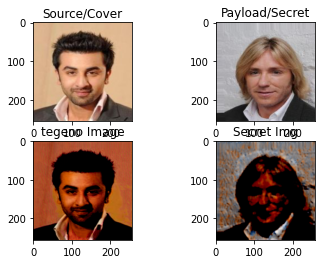

torch.Size([256, 256, 3])


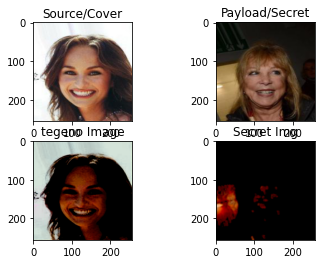

torch.Size([256, 256, 3])


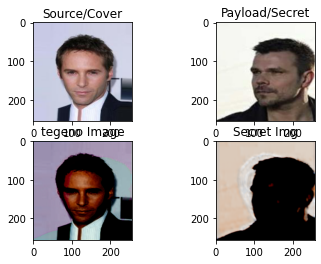

torch.Size([256, 256, 3])


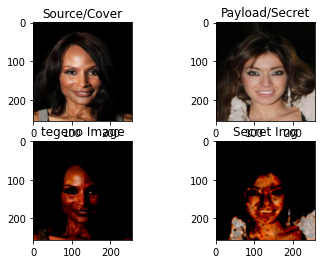

torch.Size([256, 256, 3])


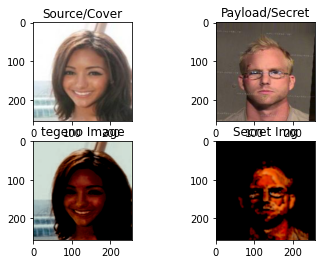

Epoch: 2
torch.Size([256, 256, 3])


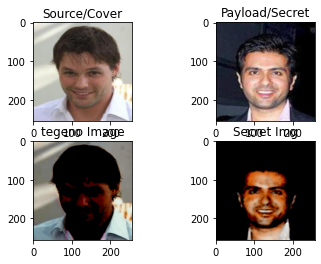

torch.Size([256, 256, 3])


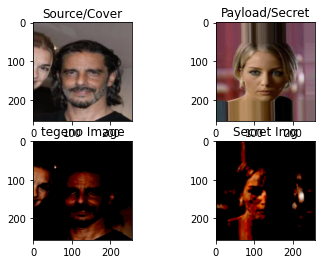

torch.Size([256, 256, 3])


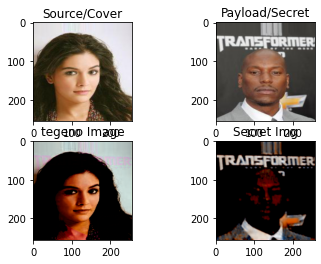

torch.Size([256, 256, 3])


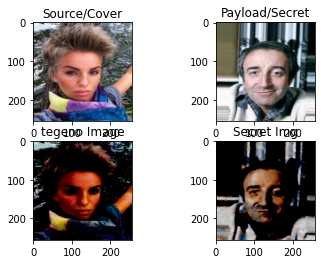

torch.Size([256, 256, 3])


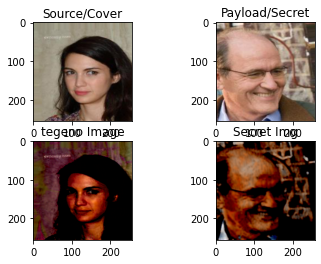

KeyboardInterrupt: ignored

In [70]:
for epoch in range(num_epochs):
  train_loss = 0
  print("Epoch:", epoch+1)
  for i, (s,p) in enumerate(zip(s_test,p_test)):
    if i < 5:
      s, _ = s  #cover
      p, _ = p  #secret'
      s = s.to(device)
      p = p.to(device)

      stegono_img = encoder(s,p)
      output = decoder(stegono_img)

      s = s[0,:,:,:].permute(1,2,0).cpu()
      p = p[0,:,:,:].permute(1,2,0).cpu()
      stegono_img = stegono_img[0,:,:,:].permute(1,2,0).cpu()
      output = output[0,:,:,:].permute(1,2,0).cpu()
      print(s.shape)
      plt.subplot(221)
      plt.imshow((s+1)/2)
      plt.title("Source/Cover")
      plt.subplot(222)
      plt.imshow((p+1)/2)
      plt.title("Payload/Secret")
      plt.subplot(223)
      st = (stegono_img.detach().numpy())
      plt.imshow((st-st.min())/(st.max()-st.min()))
      plt.title("tegeno Image")
      plt.subplot(224)
      op = output.detach().numpy()
      plt.imshow((op-op.min())/(op.max()-op.min()))
      plt.title("Secret Img")
      plt.show()

In [74]:
op.max()

1.1322242